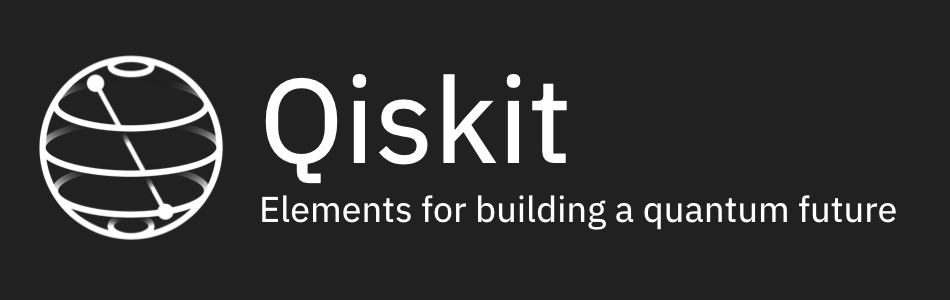

### Randomized Benchmarking
---

* **Last Updated:** March 23, 2020
* **Requires:** qiskit-terra 0.11, qiskit-ignis 0.3, qiskit-aer 0.3.4


## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. 

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module. This particular example shows how to run 2-qubit randomized benchmarking (RB) simultaneous with 1-qubit RB. There are also examples on how to use some of the companion functions for predicting RB fidelity.

In [22]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

## Select the Parameters of the RB Run

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In this example we have 3 qubits Q0,Q1,Q2. 
We are running 2Q RB (on qubits Q0,Q2) and 1Q RB (on qubit Q1) simultaneously, 
where there are twice as many 1Q Clifford gates.

In [2]:
#Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0,2],[1]]
#Do three times as many 1Q Cliffords
length_multiplier = [1,3]

## Generate RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [3]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence:

In [4]:
print(rb_circs[0][0])

         ┌───┐                      ┌───┐         ┌───┐       ░ ┌───┐          »
qr_0: |0>┤ H ├──────────────■───────┤ X ├─────■───┤ X ├───────░─┤ X ├──────────»
         ├───┤┌─────┐┌───┐  │  ┌───┐└─┬─┘ ░   │  ┌┴───┴┐┌───┐ ░ └─░─┘┌───┐┌───┐»
qr_1: |0>┤ H ├┤ Sdg ├┤ H ├──┼──┤ Y ├──┼───░───┼──┤ Sdg ├┤ H ├─────░──┤ H ├┤ Z ├»
         ├───┤└┬───┬┘├───┤┌─┴─┐└───┘  │   ░ ┌─┴─┐└─────┘└───┘ ░   ░  └───┘└───┘»
qr_2: |0>┤ H ├─┤ H ├─┤ S ├┤ X ├───────■─────┤ X ├─────────────░────────────────»
         └───┘ └───┘ └───┘└───┘             └───┘             ░                »
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_2: 0 ══════════════════════════════════════════════════════════════════════»
                            

## Look at the Unitary for 1 Circuit

The Unitary representing each RB circuit should be the identity (with a global phase),
since we multiply random Clifford elements, including a computed reversal gate. We simulate this using an Aer unitary simulator.

In [5]:
#Create a new circuit without the measurement
qc = qiskit.QuantumCircuit(*rb_circs[0][-1].qregs,*rb_circs[0][-1].cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [6]:
#The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1', 'u2', 'u3', 'cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(), 3))

[[ 0.+1.j  0.+0.j -0.-0.j -0.-0.j -0.+0.j  0.+0.j  0.-0.j  0.-0.j]
 [-0.-0.j  0.+1.j  0.+0.j -0.-0.j -0.-0.j  0.-0.j  0.+0.j  0.+0.j]
 [-0.+0.j -0.+0.j  0.+1.j  0.+0.j -0.+0.j -0.-0.j -0.+0.j -0.-0.j]
 [ 0.-0.j -0.+0.j -0.-0.j  0.+1.j -0.-0.j -0.-0.j  0.-0.j -0.-0.j]
 [-0.-0.j -0.+0.j  0.+0.j -0.-0.j  0.+1.j -0.-0.j -0.-0.j  0.-0.j]
 [-0.-0.j -0.+0.j  0.+0.j  0.-0.j -0.+0.j  0.+1.j  0.+0.j -0.-0.j]
 [ 0.-0.j  0.-0.j -0.-0.j  0.+0.j -0.+0.j -0.+0.j  0.+1.j -0.-0.j]
 [-0.+0.j -0.-0.j -0.-0.j -0.+0.j  0.-0.j -0.+0.j -0.+0.j  0.+1.j]]


## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [7]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

## Execute on Aer simulator

We can execute the RB sequences either using a Qiskit Aer Simulator (with some noise model) or using an IBMQ provider, 
and obtain a list of results, `result_list`.

In [8]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
result_list = []
transpile_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


## Get statistics about the survival probabilities

The results in **result_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

From $\alpha$ we can calculate the **Error per Clifford (EPC)**:
$$ EPC = \frac{2^n-1}{2^n} (1-\alpha)$$
(where $n=nQ$ is the number of qubits).

In [9]:
#Create an RBFitter object with 1 seed of data
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_opts['rb_pattern'])

### Plot After 1 Seed

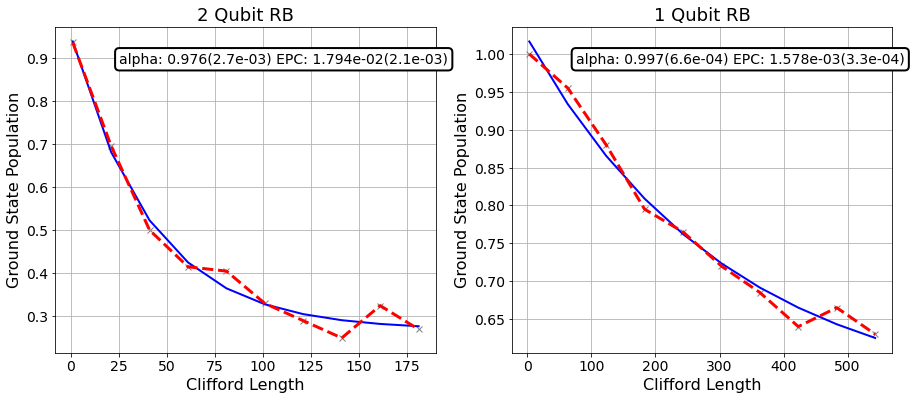

In [10]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

### Plot with the Rest of the Seeds 
The plot is being updated after each seed.

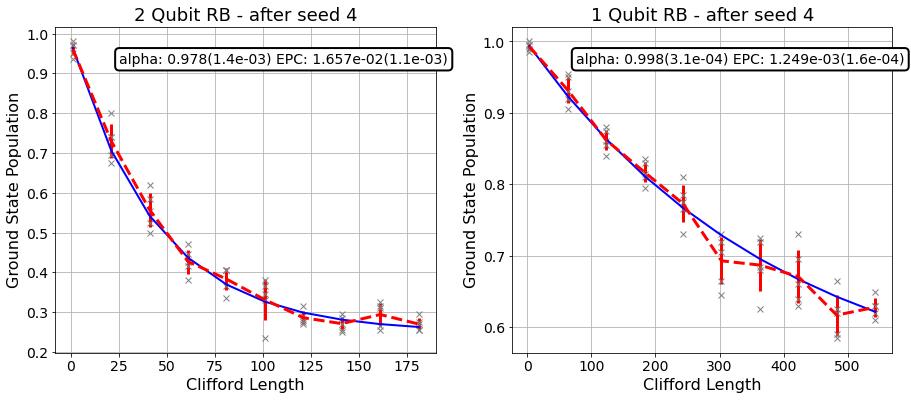

In [11]:
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(15, 6))
    axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(2):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

### Add more shots to the data

In [12]:
shots = 200
result_list = []
transpile_list = []
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


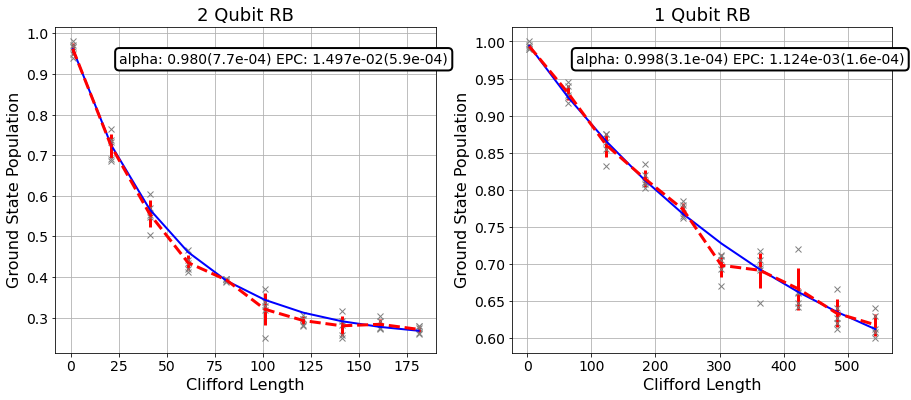

In [13]:
#Add this data to the previous fit
rbfit.add_data(result_list)

#Replot
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

### Predicted Gate Fidelity

From the known depolarizing errors on the simulation we can predict the **fidelity**. 
First we need to count the number of **gates per Clifford**.

The function **gates_per_clifford** takes a compiled qobj and outputs the number of basis gates in each circuit.

In [14]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Clifford: %f "%(basis_gates[i],
                                                  np.mean([gates_per_cliff[0][basis_gates[i]],
                                                           gates_per_cliff[2][basis_gates[i]]])))

Number of u1 gates per Clifford: 0.248804 
Number of u2 gates per Clifford: 0.952717 
Number of u3 gates per Clifford: 0.501196 
Number of cx gates per Clifford: 1.502609 


The **two-qubit Clifford gate error** gives measured errors in the basis gates that were used to construct the Clifford. 
It assumes that the error in the underlying gates is depolarizing. It outputs the error per a 2-qubit Clifford.

The input to this function is:
- **ngates:** list of the number of gates per 2Q Clifford.
- **gate_qubit:** list of the qubit corresponding to the gate (0, 1 or -1). -1 corresponds to the 2Q gate.
- **gate_err:** list of the gate errors.

In [15]:
#Prepare lists of the number of qubits and the errors
ngates = gates_per_cliff
gate_qubits = np.array([0,0,0,1,1,1,-1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))
gate_errs[[1,4]] = p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[[2,5]] = 2*p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[6] = p2Q*3/4 #convert from depolarizing error to epg (2Q)

#Calculate the predicted epc
pred_epc = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 2.397600e-03


## Run an RB Sequence with T1,T2 Errors

We now choose RB sequences that contain only 2-qubit Cliffords.

We execute these sequences as before, but with a noise model extended with T1/T2 thermal relaxation error, and fit the exponentially decaying curve. 

In [16]:
rb_opts2 = rb_opts.copy()
rb_opts2['rb_pattern'] = [[0,1]]
rb_opts2['length_multiplier'] = 1
rb_circs2, xdata2 = rb.randomized_benchmarking_seq(**rb_opts2)

noise_model2 = NoiseModel()

#Add T1/T2 noise to the simulation
t1 = 100.
t2 = 80.
gate1Q = 0.1
gate2Q = 0.5
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
noise_model2.add_all_qubit_quantum_error(
    thermal_relaxation_error(t1,t2,gate2Q).tensor(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

In [17]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 500
result_list2 = []
transpile_list2 = []
for rb_seed,rb_circ_seed in enumerate(rb_circs2):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list2.append(job.result())
    transpile_list2.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


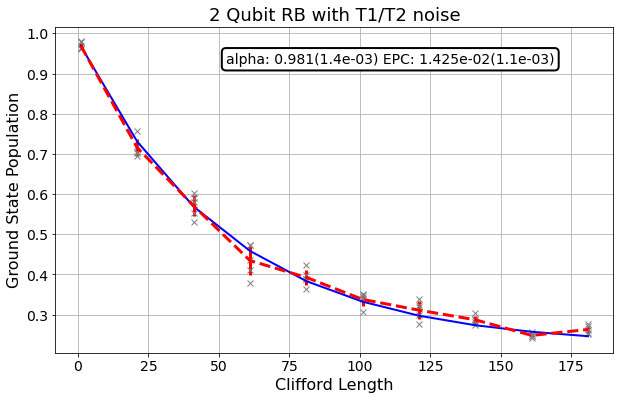

In [18]:
#Create an RBFitter object 
rbfit = rb.RBFitter(result_list2, xdata2, rb_opts2['rb_pattern'])

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
rbfit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)

# Add title and label
ax.set_title('2 Qubit RB with T1/T2 noise', fontsize=18)

plt.show()

We count again the number of **gates per Clifford** as before, and calculate the **two-qubit Clifford gate error**, using the predicted primitive gate errors from the coherence limit.

In [19]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list2,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Clifford: %f "%(basis_gates[i],
                                                  np.mean([gates_per_cliff[0][basis_gates[i]],
                                                           gates_per_cliff[2][basis_gates[i]]])))

Number of u1 gates per Clifford: 0.127935 
Number of u2 gates per Clifford: 0.471848 
Number of u3 gates per Clifford: 0.247500 
Number of cx gates per Clifford: 0.746304 


In [20]:
#Prepare lists of the number of qubits and the errors
ngates = gates_per_cliff
gate_qubits = np.array([0,0,0,1,1,1,-1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))

#Here are the predicted primitive gate errors from the coherence limit
gate_errs[[1,4]] = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q) 
gate_errs[[2,5]] = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q) 
gate_errs[6] = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q) 

#Calculate the predicted epc
pred_epc = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.398360e-03


In [21]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright